# Binary Group Composition on $C_n \times C_n$

**Group:** Product of cyclic groups $C_n \times C_n$ of order $n^2$.  
**Task:** Given encodings of two group elements $g_1, g_2 \in C_n \times C_n$, predict the encoding of their product.  
**Sequence length:** $k = 2$ (binary composition).  
**Architecture:** `TwoLayerNet` with square nonlinearity.  
**Key result:** The network learns one irreducible representation at a time.

## Imports

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import src.dataset as dataset
import src.model as model
import src.power as power
import src.template as template
import src.train as train_mod
import src.viz as viz

## Configuration

In [2]:
TEST_MODE = os.environ.get("NOTEBOOK_TEST_MODE", "0") == "1"

seed = 47
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

n = 3 if TEST_MODE else 5
group_size = n * n

hidden_size = 32 if TEST_MODE else 128
epochs = 2 if TEST_MODE else 1000
lr = 0.001
init_scale = 1e-2
batch_size = 32 if TEST_MODE else 128

FIGURES_DIR = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"Group: C_{n} x C_{n}, order {group_size}")

Group: C_5 x C_5, order 25


## Template and Dataset

In [3]:
# Build a fixed CnxCn template with known Fourier structure
fourier_coef_mags = np.random.RandomState(seed).rand(n) * 10
tpl = template.fixed_cnxcn(image_length=n, fourier_coef_mags=fourier_coef_mags)

# Build exhaustive dataset: all group_size^2 pairs
X, Y = dataset.cnxcn_dataset(tpl)
X_tensor, Y_tensor, device = dataset.move_dataset_to_device_and_flatten(X, Y)

ds = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=False)

print(f"Dataset: {len(ds)} samples")
print(f"X shape: {X_tensor.shape}, Y shape: {Y_tensor.shape}")

Setting mode: (1, 0) with magnitude: 9.744830944364566
Setting mode: (0, 1) with magnitude: 7.287346335011062
Setting mode: (1, 1) with magnitude: 3.5146780589270143
Setting mode: (2, 0) with magnitude: 7.07605138259081
GPU is available. Using CUDA.
Dataset: 625 samples
X shape: torch.Size([625, 50]), Y shape: torch.Size([625, 25])


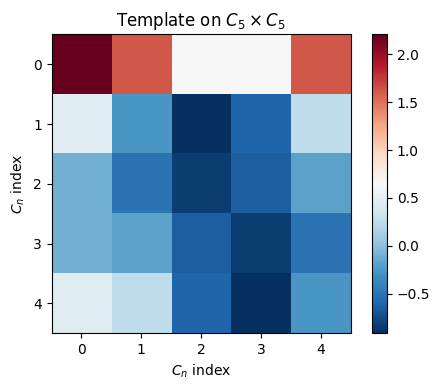

In [4]:
# Visualize template as 2D image
tpl_2d = tpl.reshape(n, n) if tpl.ndim == 1 else tpl

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(tpl_2d, cmap="RdBu_r")
ax.set_xlabel("$C_n$ index")
ax.set_ylabel("$C_n$ index")
ax.set_title(f"Template on $C_{{{n}}} \\times C_{{{n}}}$")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/cnxcn_template.pdf", bbox_inches="tight")
plt.show()

## Model and Optimizer

In [5]:
net = model.TwoLayerNet(
    group_size=group_size,
    hidden_size=hidden_size,
    nonlinearity="square",
    init_scale=init_scale,
)
net = net.to(device)

criterion = nn.MSELoss()
opt = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))

print(f"Model: TwoLayerNet(group_size={group_size}, hidden={hidden_size})")
print(f"Optimizer: Adam(lr={lr})")
print(f"Training for {epochs} epochs")

Model: TwoLayerNet(group_size=25, hidden=128)
Optimizer: Adam(lr=0.001)
Training for 1000 epochs


## Training

In [6]:
loss_history, val_loss_history, param_history, param_save_epochs, final_epoch = train_mod.train(
    net,
    dataloader,
    criterion,
    opt,
    epochs=epochs,
    verbose_interval=max(1, epochs // 10),
    save_param_interval=max(1, epochs // 100),
)

[Epoch   100/1000] loss: 0.039540 | reduction:   94.1%
[Epoch   200/1000] loss: 0.039536 | reduction:   94.1%
[Epoch   300/1000] loss: 0.040086 | reduction:   94.0%
[Epoch   400/1000] loss: 0.018636 | reduction:   97.2%
[Epoch   500/1000] loss: 0.007016 | reduction:   99.0%
[Epoch   600/1000] loss: 0.006604 | reduction:   99.0%
[Epoch   700/1000] loss: 0.000407 | reduction:   99.9%
[Epoch   800/1000] loss: 0.000358 | reduction:   99.9%
[Epoch   900/1000] loss: 0.000289 | reduction:  100.0%
[Epoch  1000/1000] loss: 0.000016 | reduction:  100.0%


## Training Loss

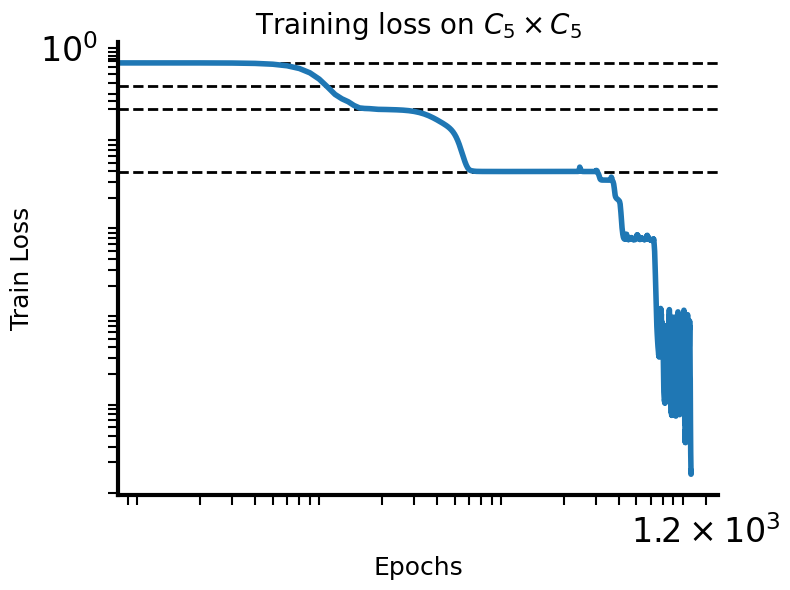

In [7]:
# Compute theoretical loss plateau levels
theory = power.theoretical_loss_levels_2d(tpl_2d)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loss_history, lw=4)

for level in theory["levels"]:
    ax.axhline(y=level, color="black", linestyle="--", linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Train Loss", fontsize=18)
ax.set_title(f"Training loss on $C_{{{n}}} \\times C_{{{n}}}$", fontsize=20)
viz.style_axes(ax)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/cnxcn_loss.pdf", bbox_inches="tight")
plt.show()

## Predictions

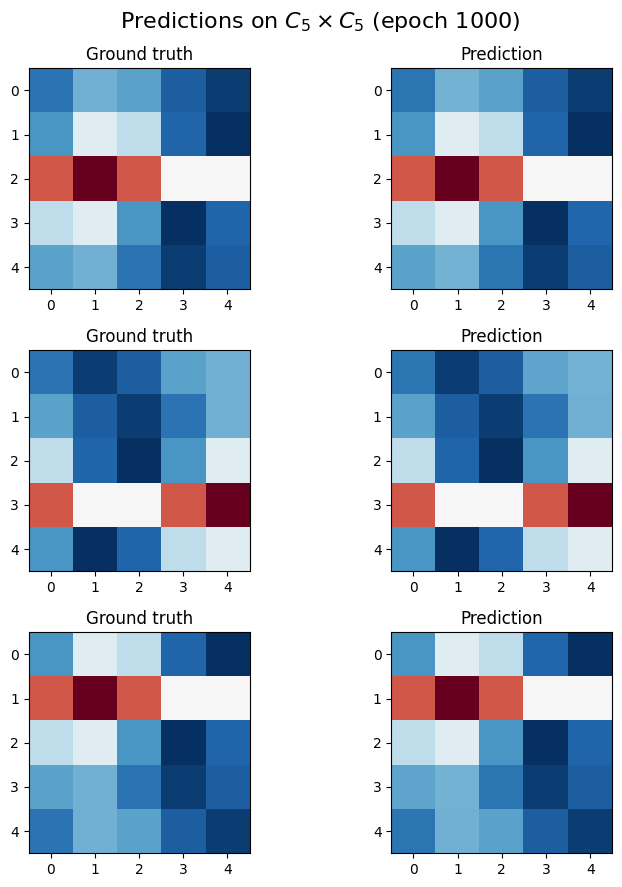

In [8]:
# Show a few predictions vs ground truth
net.load_state_dict(param_history[-1])
net.eval()

n_examples = 3
indices = np.random.choice(len(Y_tensor), size=n_examples, replace=False)

fig, axes = plt.subplots(n_examples, 2, figsize=(8, 3 * n_examples))

with torch.no_grad():
    preds = net(X_tensor[indices]).detach().cpu().numpy()
    truths = Y_tensor[indices].detach().cpu().numpy()

for i in range(n_examples):
    axes[i, 0].imshow(truths[i].reshape(n, n), cmap="RdBu_r")
    axes[i, 0].set_title("Ground truth")
    axes[i, 1].imshow(preds[i].reshape(n, n), cmap="RdBu_r")
    axes[i, 1].set_title("Prediction")

plt.suptitle(f"Predictions on $C_{{{n}}} \\times C_{{{n}}}$ (epoch {final_epoch})", fontsize=16)
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/cnxcn_predictions.pdf", bbox_inches="tight")
plt.show()